# xgboost-shap 으로 피처 중요도 시각화하기

입력파일:`dynamics-and-category-assigned-results.xlsx`
- 패널의 각 레이블 데이터마다, 카테고리, 키워드, 타입, 커뮤니티, 커뮤니티 지속일 등을 부여한 데이터

모델링
- 입력 피쳐
  - trial_idx: 1 ~ 7: 날짜 인덱스
  - trial_pos: 0 ~: 날짜별 노출 순위 (0이 최상위)
  - type: 'persisting', 'new', 'merging', 'expanding', 'split', 'shrinking' 중 하나
  - community: 209가지 커뮤니티 중 하나
  - streak_count: type이 'persisting'일 이면 1 이상의 지속일. (그외에는 빈값이지만 내부에서 0으로 설정함)
- 타겟
  - satisfaction: 만족도


아이디어
- xgboost 모델로 만족도를 예측하고, shap을 사용하여 피쳐 중요도를 시각화한다.

In [1]:
import pandas as pd

### matplotlib 이 한글 폰트 제대로 출력하기 위한 설정

In [2]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 세팅은 맥북에 해당하며, 윈도우즈는 구글 검색을 통해 다르게 해결해야 함

# 한글 폰트 설정
plt.rcParams['font.family'] = 'AppleGothic'  # 'NanumGothic' 등 다른 폰트도 사용 가능
plt.rcParams['axes.unicode_minus'] = False   # 마이너스 기호 깨짐 방지

# 한글 폰트가 제대로 설정됐는지 확인
print([f.name for f in fm.fontManager.ttflist if 'Gothic' in f.name])


['Hiragino Maru Gothic Pro', 'Apple SD Gothic Neo', 'Noto Sans Gothic', 'AppleGothic']


# 데이터 처리

## 데이터 로딩

In [3]:
input_file_path = '../local_data/dynamics-and-category-assigned-results.xlsx'

In [4]:
def add_trial_pos(source_df:pd.DataFrame):
    '''
    trial_idx > 0 인 것만 남기고,
    trial_pos 를 추가하여 반환한다. (일별 노출 포지션)
    '''
    df = source_df.query('trial_idx > 0').copy()
    df['trial_pos'] = df.groupby('trial_idx').cumcount()
    return df


최병건, 최지원은 제외시킴

In [5]:
df = pd.concat([add_trial_pos(v) for k, v in pd.read_excel(input_file_path, sheet_name=None).items() if k not in ['최병건', '최지원']])

In [6]:
df.fillna({'streak_count':0}, inplace=True)
df.dropna(inplace=True)

In [7]:
df.head(n=2)

,source,issue-dt,title,precision,freshness,satisfaction,trial_idx,dt,category,keywords,type,community,streak_count,trial_pos
5,매일경제,1일,"낡은 23평 아파트 20억에 팔렸다…‘신고가’ 기록, 어느 동네길래",10.0,8.0,10.0,1,415,2.3. 부동산,"['아파트', '20억', '신고가']",new,"('2.3. 부동산',)",0.0,0
6,지큐 코리아(GQ Korea),6일,피로는 간 때문일까? 간을 망치는 습관들,6.0,8.0,8.0,1,415,4.1. 건강,"['피로', '간', '습관']",new,"('4.1. 건강', '5.5. 과학 일반')",0.0,1


## 데이터 전처리

In [8]:
input_columns = ['trial_idx', 'trial_pos', 'type', 'community',
       'streak_count']

target_column = ['satisfaction']

일부 실수값으로 되어 있는 컬럼 -> 정수로 변환

In [9]:
int_columns = ['streak_count', 'satisfaction']
df[int_columns] = df[int_columns].astype(int)

# OneHotEncoder 피쳐 추가

대상 (카테고리 피쳐)
- type: 유니크하게 6개
- community: 유니크하게 209개

각각을 펼쳐서 다음과 같은 개별 바이너리 컬럼 들로 표현함

```text
    'type_expanding', 'type_merging', 'type_new', 'type_persisting',
    'type_shrinking', 'type_split',
    "community_('1.1.1. 청와대/행정부', '2.3. 부동산')",
    "community_('1.1.1. 청와대/행정부', '7.3. 음악')",
    ...
    ```

In [10]:
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

# OneHotEncoder 인스턴스 생성
onehot_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

# type과 community 열에 대해 원-핫 인코딩 수행
encoded_features = onehot_encoder.fit_transform(df[['type', 'community']])

# 새로운 열 이름 생성
encoded_columns = onehot_encoder.get_feature_names_out(['type', 'community'])

# # 원-핫 인코딩 결과를 DataFrame으로 변환
encoded_df = pd.DataFrame(encoded_features, columns=encoded_columns)

# # 기존 DataFrame에 결합
input_df = pd.concat([df[['trial_idx', 'trial_pos', 'streak_count']].reset_index(drop=True), encoded_df], axis=1)

# 훈련

In [11]:
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import root_mean_squared_error

In [12]:
# OneHotEncoder 사용
X_train, X_val, y_train, y_val = train_test_split(input_df, df[target_column], test_size=0.2, random_state=42)

## XGBoost 훈련

훈련 성능이 중요한게 아니라 통상적인 설정으로 훈련시킴
- 회귀 모형 (regression): `satisfaction` 을 예측
- 훈련:검증 = 8:2로 설정

검증 결과 (SHAP 관찰이 목적이기 때문에 수치는 큰 의미는 없음)
- RMSE가 2.42 정도 (대략 만족도 예측의 오차가 2.42 정도를 의미)

In [13]:
xgb_model = XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=7,
    subsample=0.8,  # Use 80% of training data for each boosting round
    colsample_bytree=0.8,  # Use 80% of features for each boosting round
    random_state=42,
    early_stopping_rounds=10
)

# Train the model with early stopping
xgb_model.fit(
    X_train,
    y_train,
    eval_set=[(X_val, y_val)],
    verbose=False  # Suppress the training output for brevity
)

# Predict on the validation set
y_pred = xgb_model.predict(X_val)

# Calculate and display RMSE for validation
rmse = root_mean_squared_error(y_val, y_pred)
rmse

2.278505299756279

## XGBoost 피쳐 중요도

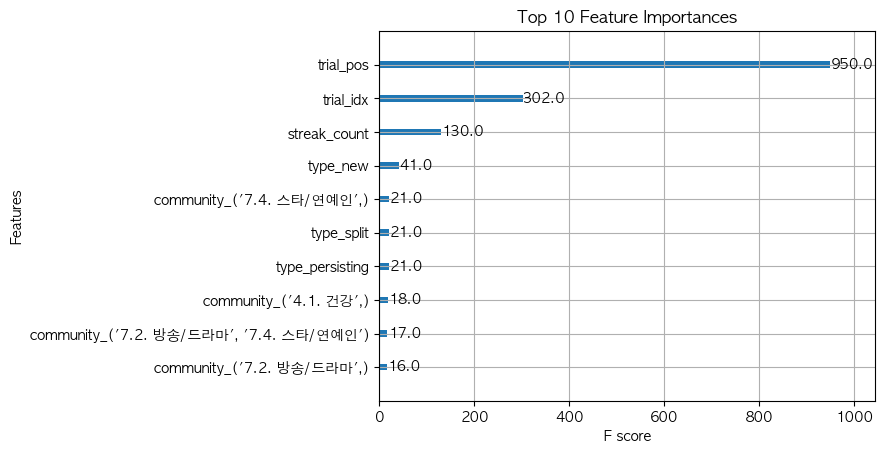

In [14]:
import matplotlib.pyplot as plt
import xgboost as xgb

# Plot feature importance
xgb.plot_importance(xgb_model, max_num_features=10)
plt.title("Top 10 Feature Importances")
plt.show()

# SHAP 분석

In [15]:
df.type.value_counts().index

Index(['persisting', 'new', 'merging', 'expanding', 'split', 'shrinking'], dtype='object', name='type')

SHAP value
- 모델 출력 (만족도 예측)에 미치는 영향도 (+: 값을 증가시키는 영향, -: 값을 감소시키는 영향)
- 빨간 정도: 각 피쳐의 값이 클수록 선명
- 파란 정도: 각 피쳐의 값이 작을수록 선명

영향력이 큰 피쳐
- trial_pos: 이는 노출 위치를 나타낸다 (0이 최상위)
  - 노출 위치가 상위 일수록 (0이 최상위이므로 파란색 일수록) SHAP value가 + 인 경우가 잦음 (높은 만족도)
  - 노출 위치가 하위 일수록 SHAP value 가 - 인 경우가 잦음 (낮은 만족도)
- commmunity (7.4. 스타/연예인, ): 바이너리 피쳐임으로 등장하면 1, 아니면 0
  - 대부분 SHAP value 가 - 임으로 모델 출력을 감소 시킴(낮은 만족도)
- commmunity (4.1. 건강, ): 바이너리 피쳐임으로 등장하면 1, 아니면 0
  - 대부분 SHAP value 가 + 임으로 모델 출력을 증가 시킴(높은 만족도)
- type_merging: 바이너리 피쳐임으로 등장하면 1, 아니면 0
  - 이는 전날 대비 병합된 커뮤니티를 의미하는데, SHAP value 를 약간 -가 되게 함 (만족도 감소에 다소 영향 미침)
- type_new: 바이너리 피쳐임으로 등장하면 1, 아니면 0
  - 이는 신규 커뮤니티를 의미하는데, SHAP value 를 약간 +가 되게 함 (만족도 증가에 다소 영향 미침)
- type_expanding: 바이너리 피쳐임으로 등장하면 1, 아니면 0
  - 이는 확장된 커뮤니티를 의미하는데, SHAP value 를 약간 +가 되게 함 (만족도 증가에 다소 영향 미침)
- streak_count: 커뮤니티 타입인 type_persisting 일 때 연속된 날짜 수임 (단, type_persisting이 아닐 때는 모두 0으로 지정했기 때문에 순수 파란색은 무시해야 함)
  - 점들이 혼재되어 있지만, 장기간 지속 될 경우 SHAP value에 다소 -가 됨 (만족도 감소에 다소 영향 미침)

In [17]:
import shap

/Users/jangmin/anaconda3/envs/metal/lib/python3.10/site-packages/shap/plots/_beeswarm.py:950: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  pl.tight_layout()


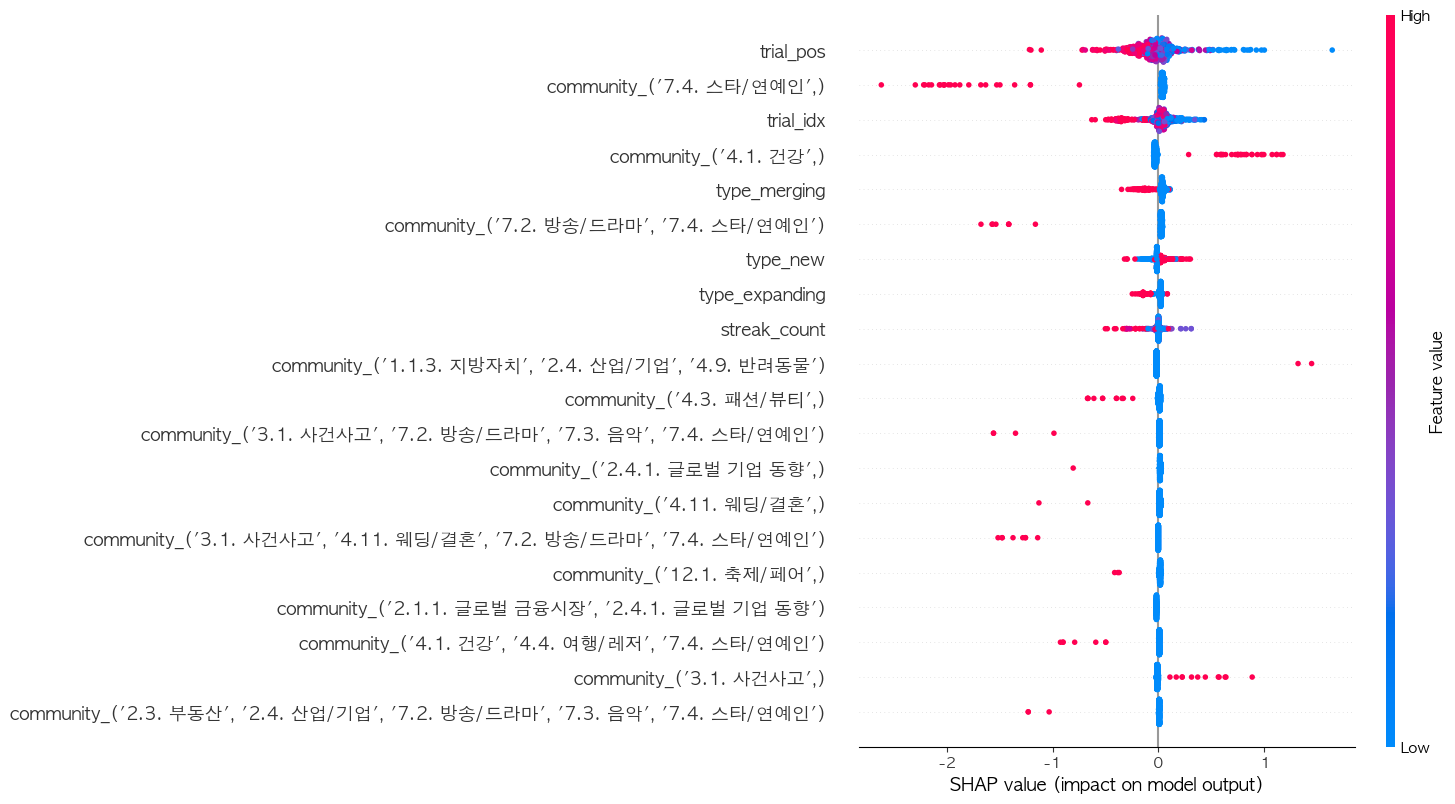

In [18]:
# Initialize the SHAP explainer
explainer = shap.Explainer(xgb_model, X_train)

# Calculate SHAP values for the validation set
shap_values = explainer(X_val)

# Summary plot to show feature importance and distribution of impacts
shap.summary_plot(shap_values, X_val)